# Classification with Support Vector Machine

## Import libraries and data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.svm import SVC

Set rng seed.

In [2]:
seed = 17

Take a look at the data (processing has already taken place as part of the exploratory data analysis step).

In [3]:
df = pd.read_csv("data/train_prepd.csv")

In [4]:
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
0,0.0,3.0,22.0,7.2500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,71.2833,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,7.9250,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,3.0,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


dims:  (891, 13)


In [5]:
df.describe()

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.951235,32.204208,0.904602,0.647587,0.086420,0.722783,0.204265,0.580247,0.140292,0.030303,0.771044
std,0.486592,0.836071,14.176038,49.693429,1.613459,0.477990,0.281141,0.447876,0.403390,0.493796,0.347485,0.171516,0.420397
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,28.000000,14.454200,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,38.000000,31.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split dependent and independent variables

In [6]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Split into training and test set

The dataset is fairly imbalanced (38% survived), so we'll use stratification in the train/test split.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)
X_train

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
877,3.0,19.000000,7.8958,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
796,1.0,49.000000,25.9292,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
736,3.0,48.000000,34.3750,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
604,1.0,35.000000,26.5500,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
557,1.0,38.136611,227.5250,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
423,3.0,28.000000,14.4000,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
686,3.0,14.000000,39.6875,5.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
804,3.0,27.000000,6.9750,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
119,3.0,2.000000,31.2750,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


## Feature scaling

Feature scaling is essential for Support Vector Machines. I will try a couple different methods. From data exploration we noticed that Age is not very far from being normally distributed. Fare is definitely not normally distributed (more like log-normal) and has extreme outliers.

### Standardize everything (incl. dummies)

In [16]:
standardizer1 = StandardScaler()
X_train_st_all = standardizer1.fit_transform(X_train)
X_test_st_all = standardizer1.transform(X_test)
display(pd.DataFrame(X_train_st_all))

# Also feature scale the entire training set to use later in cross validation.
X_st_all = standardizer1.fit_transform(X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.825894,-0.769597,-0.482316,-0.568141,0.746985,-0.280692,0.596817,-0.510075,0.855780,-0.408917,-0.182707,0.544888
1,-1.569367,1.379429,-0.131908,-0.568141,-1.338715,-0.280692,0.596817,-0.510075,-1.168524,-0.408917,5.473255,-1.835238
2,0.825894,1.307795,0.032203,1.890927,-1.338715,-0.280692,0.596817,-0.510075,-1.168524,2.445484,-0.182707,0.544888
3,-1.569367,0.376550,-0.119845,-0.568141,0.746985,-0.280692,-1.675556,-0.510075,0.855780,-0.408917,-0.182707,0.544888
4,-1.569367,0.601239,3.785316,-0.568141,0.746985,-0.280692,-1.675556,-0.510075,0.855780,-0.408917,-0.182707,0.544888
...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.825894,-0.124889,-0.355932,0.661393,-1.338715,-0.280692,0.596817,-0.510075,-1.168524,2.445484,-0.182707,0.544888
708,0.825894,-1.127767,0.135431,2.505694,0.746985,-0.280692,0.596817,-0.510075,0.855780,-0.408917,-0.182707,0.544888
709,0.825894,-0.196523,-0.500208,-0.568141,0.746985,-0.280692,0.596817,-0.510075,0.855780,-0.408917,-0.182707,0.544888
710,0.825894,-1.987378,-0.028033,3.120461,-1.338715,-0.280692,0.596817,1.960494,-1.168524,-0.408917,-0.182707,0.544888


### Normalize everything

In [19]:
normalizer1 = MinMaxScaler()
X_train_norm_all = normalizer1.fit_transform(X_train)
X_test_norm_all = normalizer1.transform(X_test)
display(pd.DataFrame(X_train_norm_all))


# Also feature scale the entire training set to use later in cross validation.
X_norm_all = normalizer1.fit_transform(X)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.252514,0.015412,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.660234,0.050610,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.646643,0.067096,0.4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.469965,0.051822,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.512593,0.444099,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
707,1.0,0.374830,0.028107,0.2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
708,1.0,0.184561,0.077465,0.5,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
709,1.0,0.361239,0.013614,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
710,1.0,0.021473,0.061045,0.6,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### Standardize Numeric only

In [20]:
standardizer2 = StandardScaler()
X_train_st_some = X_train.copy()
X_train_st_some[['Age', 'Fare', 'FamSize', 'Pclass']] = standardizer2.fit_transform(X_train_st_some[['Age', 'Fare', 'FamSize', 'Pclass']])
X_test_st_some = X_test.copy()
X_test_st_some[['Age', 'Fare', 'FamSize', 'Pclass']] = standardizer2.transform(X_test_st_some[['Age', 'Fare', 'FamSize', 'Pclass']])
display(X_train_st_some)

# Also feature scale the entire training set to use later in cross validation.
X_st_some = X.copy()
X_st_some[['Age', 'Fare', 'FamSize', 'Pclass']] = standardizer2.fit_transform(X_st_some[['Age', 'Fare', 'FamSize', 'Pclass']])

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
877,0.825894,-0.769597,-0.482316,-0.568141,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
796,-1.569367,1.379429,-0.131908,-0.568141,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
736,0.825894,1.307795,0.032203,1.890927,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
604,-1.569367,0.376550,-0.119845,-0.568141,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
557,-1.569367,0.601239,3.785316,-0.568141,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.825894,-0.124889,-0.355932,0.661393,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
686,0.825894,-1.127767,0.135431,2.505694,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
804,0.825894,-0.196523,-0.500208,-0.568141,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
119,0.825894,-1.987378,-0.028033,3.120461,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### Mix of standardization and normalization

In [26]:
normalizer2 = MinMaxScaler()
standardizer3 = StandardScaler()

# Normalize 'Fare', as it does not follow a Gaussian distribution, and I would like to preserve it.
# Standardize everything else except for dummies

X_train_fs = X_train.copy()
X_test_fs = X_test.copy()
X_train_fs[['Fare']] = normalizer2.fit_transform(X_train_fs[['Fare']])
X_test_fs[['Fare']] = normalizer2.transform(X_test_fs[['Fare']])
X_train_fs[['Pclass', 'Age', 'FamSize']] = standardizer3.fit_transform(X_train_fs[['Pclass', 'Age', 'FamSize']])
X_test_fs[['Pclass', 'Age', 'FamSize']] = standardizer3.transform(X_test_fs[['Pclass', 'Age', 'FamSize']])
display(X_train_fs)

# Also feature scale the entire training set to use later in cross validation.
X_fs = X.copy()
X_fs[['Fare']] = normalizer2.fit_transform(X_fs[['Fare']])
X_fs[['Pclass', 'Age', 'FamSize']] = standardizer3.fit_transform(X_fs[['Pclass', 'Age', 'FamSize']])

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
877,0.825894,-0.769597,0.015412,-0.568141,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
796,-1.569367,1.379429,0.050610,-0.568141,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
736,0.825894,1.307795,0.067096,1.890927,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
604,-1.569367,0.376550,0.051822,-0.568141,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
557,-1.569367,0.601239,0.444099,-0.568141,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.825894,-0.124889,0.028107,0.661393,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
686,0.825894,-1.127767,0.077465,2.505694,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
804,0.825894,-0.196523,0.013614,-0.568141,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
119,0.825894,-1.987378,0.061045,3.120461,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


## Preliminary model

Build the most basic SVC and get an initial feel about what we can do with SVM and which feature scaling approach will work best. We will use simple train/test splits.

### Without feature scaling

In [31]:
#train
classifier = SVC(kernel = 'linear', random_state = seed)
classifier.fit(X_train, y_train)

#predict
y_pred = classifier.predict(X_test)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8324022346368715
[[98 12]
 [18 51]]


### With all features standardized

In [32]:
#train
classifier = SVC(kernel = 'linear', random_state = seed)
classifier.fit(X_train_st_all, y_train)

#predict
y_pred = classifier.predict(X_test_st_all)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8268156424581006
[[98 12]
 [19 50]]


### With all features normalized

In [33]:
#train
classifier = SVC(kernel = 'linear', random_state = seed)
classifier.fit(X_train_norm_all, y_train)

#predict
y_pred = classifier.predict(X_test_norm_all)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8324022346368715
[[99 11]
 [19 50]]


### With only numeric features standardized

In [34]:
#train
classifier = SVC(kernel = 'linear', random_state = seed)
classifier.fit(X_train_st_some, y_train)

#predict
y_pred = classifier.predict(X_test_st_some)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8324022346368715
[[98 12]
 [18 51]]


### With mixed feature scaling

In [35]:
#train
classifier = SVC(kernel = 'linear', random_state = seed)
classifier.fit(X_train_fs, y_train)

#predict
y_pred = classifier.predict(X_test_fs)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(acc)
print(cm)

0.8324022346368715
[[98 12]
 [18 51]]


On a simple train/test split, all models except the one with all features standardized yield the same accuracy (83.24%). The model with all features standardized misclassified 1 observation more and had an accuracy of (82.68%).

We are going to use cross validation to get a better accuracy estimation, for different feature scaling techniques and different models/hyperparameters.

## Hyperparameter tuning

Here I'm using Grid Search 10-fold CV inside the entire training set (X) to find the best SVC hypermarameters. There is data leakage in the validation sets, which I'm ignoring here. I'm doing the CV for each feature scaling method to compare results.

**TODO**: Pipelines

In [36]:
parameters = [{'C': [0.25, 0.5, 0.75, 1, 10, 100], 
               'kernel': ['linear']
              },
              {'C': [0.25, 0.5, 0.75, 1, 10, 100], 
               'kernel': ['rbf'], 
               'gamma': ['scale', 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
              }]

gs = GridSearchCV(estimator=SVC(), param_grid=parameters, cv=10, scoring='accuracy')

### Standardized all

In [37]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_st_all, y)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.84 %
Best Parameters:  {'C': 0.75, 'gamma': 0.2, 'kernel': 'rbf'}
Time: 15.18


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
36,0.008708,0.000459,0.002002,1.581490e-07,0.75,rbf,0.2,"{'C': 0.75, 'gamma': 0.2, 'kernel': 'rbf'}",0.833333,0.820225,...,0.887640,0.876404,0.820225,0.831461,0.797753,0.853933,0.887640,0.838390,0.035924,1
49,0.008908,0.000300,0.002102,3.003200e-04,1,rbf,0.2,"{'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}",0.822222,0.808989,...,0.887640,0.887640,0.820225,0.831461,0.797753,0.853933,0.898876,0.837278,0.041739,2
73,0.014813,0.001471,0.001602,4.904075e-04,100,rbf,0.01,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.811111,0.842697,...,0.876404,0.887640,0.820225,0.842697,0.808989,0.853933,0.853933,0.836167,0.034362,3


### Standardized some

In [38]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_st_some, y)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start))  

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.95 %
Best Parameters:  {'C': 0.75, 'gamma': 'scale', 'kernel': 'rbf'}
Time: 15.12


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
32,0.008508,0.000671,0.002402,0.000490,0.75,rbf,scale,"{'C': 0.75, 'gamma': 'scale', 'kernel': 'rbf'}",0.822222,0.898876,...,0.898876,0.842697,0.797753,0.831461,0.797753,0.887640,0.865169,0.839526,0.046262,1
28,0.010009,0.000448,0.003103,0.000300,0.5,rbf,0.7,"{'C': 0.5, 'gamma': 0.7, 'kernel': 'rbf'}",0.800000,0.865169,...,0.876404,0.876404,0.820225,0.820225,0.820225,0.876404,0.876404,0.838427,0.040355,2
45,0.008908,0.000701,0.002402,0.000664,1,rbf,scale,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.811111,0.887640,...,0.887640,0.853933,0.808989,0.831461,0.786517,0.898876,0.865169,0.838414,0.045978,3


### Normalize all

In [39]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_norm_all, y)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.50 %
Best Parameters:  {'C': 10, 'gamma': 0.6, 'kernel': 'rbf'}
Time: 9.42


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
66,0.009509,0.000500,0.001501,0.000500,10,rbf,0.6,"{'C': 10, 'gamma': 0.6, 'kernel': 'rbf'}",0.811111,0.820225,...,0.865169,0.876404,0.820225,0.853933,0.797753,0.865169,0.876404,0.835044,0.036106,1
76,0.015814,0.002090,0.001501,0.000672,100,rbf,0.3,"{'C': 100, 'gamma': 0.3, 'kernel': 'rbf'}",0.800000,0.831461,...,0.865169,0.876404,0.831461,0.842697,0.808989,0.853933,0.853933,0.833933,0.029803,2
75,0.016915,0.002302,0.001401,0.000490,100,rbf,0.2,"{'C': 100, 'gamma': 0.2, 'kernel': 'rbf'}",0.800000,0.820225,...,0.876404,0.876404,0.831461,0.853933,0.797753,0.853933,0.865169,0.833933,0.035947,2


### No feature scaling

In [40]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X, y)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.16 %
Best Parameters:  {'C': 100, 'kernel': 'linear'}
Time: 637.43


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,49.331552,24.591304,0.001301,0.000459,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.833333,0.865169,...,0.876404,0.831461,0.797753,0.808989,0.797753,0.876404,0.853933,0.831648,0.034085,1
2,0.310182,0.075540,0.001301,0.000459,0.75,linear,NaN,"{'C': 0.75, 'kernel': 'linear'}",0.833333,0.853933,...,0.876404,0.831461,0.797753,0.808989,0.797753,0.876404,0.853933,0.830524,0.033133,2
3,0.468225,0.159744,0.001401,0.000490,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.833333,0.853933,...,0.876404,0.831461,0.797753,0.808989,0.797753,0.876404,0.853933,0.830524,0.033133,2


Note that grid search took much longer for unscaled data (10 mins. vs 10-15 seconds for the other models.)

### Mixed feature scaling

In [41]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X_fs, y)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(3)

Best Accuracy: 83.73 %
Best Parameters:  {'C': 0.75, 'gamma': 0.2, 'kernel': 'rbf'}
Time: 15.19


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
36,0.008207,0.000400,0.002602,0.000490,0.75,rbf,0.2,"{'C': 0.75, 'gamma': 0.2, 'kernel': 'rbf'}",0.811111,0.865169,...,0.898876,0.865169,0.808989,0.842697,0.775281,0.876404,0.865169,0.837291,0.042872,1
23,0.009909,0.001974,0.002802,0.000873,0.5,rbf,0.2,"{'C': 0.5, 'gamma': 0.2, 'kernel': 'rbf'}",0.811111,0.898876,...,0.898876,0.853933,0.797753,0.831461,0.786517,0.865169,0.865169,0.837291,0.044320,2
45,0.008407,0.000490,0.002502,0.000500,1,rbf,scale,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.822222,0.865169,...,0.898876,0.865169,0.820225,0.820225,0.764045,0.876404,0.865169,0.836155,0.043796,3


The best performing model is the one where only numeric features were standardized. The best values for the hyperparameters were:

- rbf kernel
- some regularization (C = 0.75)
- gamma = 'scale'

## Build and test the final model

Here:
1. Take the train dataset in the 'numeric only' standardized version.
2. Build and test on a single train/test split.
3. Take the full dataset, again in the 'numeric only' standardized version.
3. 10-fold cross validation to get a more robust estimate of how this model will perform.

As before, there is data leakage into the validation sets when I'm doing CV, which I'm ignoring for now. The proper way to do this would be, for each of the k train/validation splits in the CV to fit the scaler on the train split only, so as to not take into account the mean and st.dev of the validation set in the feature scaling process. 


Fit the Support Vector Machine with the rbf kernel and some regularization. Then predict for the test set.

Accuracy: 84.36 %


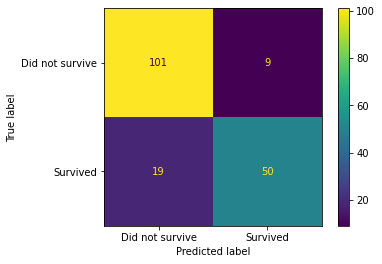

In [43]:
#train
classifier = SVC(kernel='rbf',gamma='scale', C=0.75, random_state = seed)
classifier.fit(X_train_st_some, y_train)

#predict
y_pred = classifier.predict(X_test_st_some)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(classifier, 
                     X_test_st_some,
                     y_test, display_labels=['Did not survive', 'Survived'])

Check the model with linear kernel for reference

Accuracy: 83.24 %


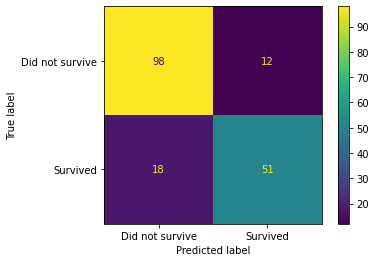

In [44]:
#train
classifier = SVC(kernel='linear', random_state = seed)
classifier.fit(X_train_st_some, y_train)

#predict
y_pred = classifier.predict(X_test_st_some)

#results
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))
plot_confusion_matrix(classifier, 
                     X_test_st_some,
                     y_test, display_labels=['Did not survive', 'Survived'])

Get a more accurate performance for the rbf model using 10-fold cross validation.

Apply the feature scaling on the entire X. (there is data leakage!)

In [46]:
# See mean, std., min and max for a quick check.
X_st_some.describe()

,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,cabin_missing
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,-8.772133e-17,-1.634807e-16,3.987333e-18,7.974666e-18,0.647587,0.086420,0.722783,0.204265,0.580247,0.140292,0.030303,0.771044
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.477990,0.281141,0.447876,0.403390,0.493796,0.347485,0.171516,0.420397
min,-1.566107e+00,-2.084350e+00,-6.484217e-01,-5.609748e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.693648e-01,-6.317888e-01,-4.891482e-01,-5.609748e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8.273772e-01,-1.377205e-01,-3.573909e-01,-5.609748e-01,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,8.273772e-01,5.680914e-01,-2.424635e-02,5.915988e-02,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,8.273772e-01,3.532502e+00,9.667167e+00,5.640372e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
# create model
classifier = SVC(kernel='rbf',gamma='scale', C=0.75, random_state = seed)

# evaluate with (repeated and stratified) 10-fold CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
scores = cross_val_score(classifier, X_st_some, y, cv=cv)

# print the results
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

scores:  [0.81111111 0.88764045 0.83146067 0.80898876 0.79775281 0.83146067
 0.83146067 0.87640449 0.85393258 0.84269663 0.8        0.80898876
 0.80898876 0.86516854 0.83146067 0.76404494 0.86516854 0.87640449
 0.87640449 0.84269663 0.91111111 0.87640449 0.87640449 0.84269663
 0.86516854 0.7752809  0.88764045 0.82022472 0.79775281 0.73033708
 0.85555556 0.80898876 0.84269663 0.78651685 0.86516854 0.85393258
 0.82022472 0.79775281 0.86516854 0.85393258 0.82222222 0.79775281
 0.84269663 0.83146067 0.78651685 0.82022472 0.91011236 0.83146067
 0.84269663 0.85393258]
Accuracy: 83.57 %
St.dev: 0.0367


Cross validated linear SVC model for reference.

In [48]:
# create model
classifier = SVC(kernel='linear', random_state = seed)

# evaluate with (repeated and stratified) 10-fold CV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
scores = cross_val_score(classifier, X_st_some, y, cv=cv)

# print the results
print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

scores:  [0.8        0.87640449 0.80898876 0.80898876 0.7752809  0.83146067
 0.84269663 0.85393258 0.86516854 0.84269663 0.8        0.79775281
 0.80898876 0.85393258 0.82022472 0.75280899 0.84269663 0.86516854
 0.88764045 0.85393258 0.9        0.86516854 0.84269663 0.84269663
 0.86516854 0.76404494 0.87640449 0.80898876 0.82022472 0.73033708
 0.84444444 0.82022472 0.83146067 0.79775281 0.83146067 0.86516854
 0.82022472 0.79775281 0.85393258 0.85393258 0.8        0.80898876
 0.84269663 0.85393258 0.7752809  0.82022472 0.8988764  0.83146067
 0.84269663 0.84269663]
Accuracy: 83.08 %
St.dev: 0.0355


We can expect about 83.6% accuracy from the final Support Vector classifier model.